In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split




%matplotlib inline

In [2]:
csv_path = 'fixed_labels2.csv'
data = pd.read_csv(csv_path,
                         index_col = False)
y_labels = []

data.columns= ['filename', 'old_label', 'type']

y_train = data["type"]

for i in range(len(y_train)):
    y_labels.append(y_train[i])
    
    
# print(data["filename"])
images_names= data["filename"].values.tolist()



In [3]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_labels)
y_train = encoder.transform(y_labels)
#y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
#print(y_train.shape)
data["one_hot"]= list(y_train)
#print(data["one_hot"])
labels= data["one_hot"].values.tolist()


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data["filename"].values.tolist(), data["one_hot"].values.tolist(),test_size=0.30,random_state=1)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [5]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1036
445
1036
445


In [6]:
def resize_image(image):
    col = 500
    row = 500
    image = cv2.resize(image,(col,row), interpolation=cv2.INTER_AREA)    
    
    plt.imshow(image)
    plt.show()
    return image

In [7]:
def preprocess_train(image_name, one_hot):  
    index = np.argmax(one_hot)+1
    type_cancer = "Type_"+ str(index)
    path_file = "train/"+type_cancer+"/"+image_name
    #print(path_file)
    image = mpimg.imread(path_file)
    image = resize_image(image)
    image = np.array(image)
    #print(one_hot)
    return image,one_hot

In [8]:
new_size_row = 500
new_size_col = 500
def generate_train_batch(data,labels,batch_size =64):
    ## Generator for trainning data
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_type = np.zeros(batch_size)
    batch_type = []
    
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
#             image_name = data["filename"][i_line]
#             type_cancer = data["type"][i_line]            
#             one_hot = list(data["one_hot"][i_line]) 
            #print(image_name,type_cancer,one_hot)
            image_name = data[i_line]          
            one_hot = labels[i_line]
    
            x,y = preprocess_train(image_name, one_hot)
            
            batch_images[i_batch] = x
            batch_type.append(y)
        
        yield batch_images, np.array(batch_type)

In [9]:
new_size_row = 500
new_size_col = 500
def generate_test_batch(data,labels,c =64):
    ## Generator for trainning data
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_type = np.zeros(batch_size)
    batch_type = []
    
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
#             image_name = data["filename"][i_line]
#             type_cancer = data["type"][i_line]            
#             one_hot = list(data["one_hot"][i_line]) 
            #print(image_name,type_cancer,one_hot)
            image_name = data[i_line]          
            one_hot = labels[i_line]
    
            x,y = preprocess_train(image_name, one_hot)
            
            batch_images[i_batch] = x
            batch_type.append(y)
        
        yield batch_images, np.array(batch_type)

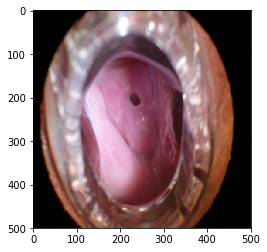

In [10]:
next(generate_train_batch(X_train,y_train,batch_size =1));

In [ ]:
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 3
batch_size = 64
num_epochs = 10
input_data_size = 750000

""" place holder for input and output values """
x = tf.placeholder('float',[None,input_data_size])
y = tf.placeholder('float')

""" Model the neural network"""
def neural_network_model(data):
    
    """output = (input_data * weights) + biases
	
	W has a shape of [784, 10] because we want
	to multiply the 784-dimensional image vectors by it 
	to produce 10-dimensional vectors of evidence for the difference classes.
	
	b has a shape of [10] so we can add it to the output."""
    
    hidden_layer_1 = {"weights":tf.Variable(tf.random_normal([input_data_size,n_nodes_hl1])),
                      "biases":tf.Variable(tf.random_normal([n_nodes_hl1]))}
    hidden_layer_2 = {"weights":tf.Variable(tf.random_normal([n_nodes_hl1,n_nodes_hl2])),
                      "biases":tf.Variable(tf.random_normal([n_nodes_hl2]))}
    hidden_layer_3 = {"weights":tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3])),
                      "biases":tf.Variable(tf.random_normal([n_nodes_hl3]))}
    output_layer = {"weights":tf.Variable(tf.random_normal([n_nodes_hl3,n_classes])),
                      "biases":tf.Variable(tf.random_normal([n_classes]))}
    
    """ For each neuron in hidden layer:
        output = activation(sum((input*weight)) + biases)
        Hidden layer 1 takes actual input data, add it's weight
        and biases, and send the output to second layer and so on. 
        Output of hidden layer 3 will be fed to output layer 
		relu - Activation funtion, Computes rectified linear: max(features, 0)
    """
    output_hl1 = tf.add(tf.matmul(data,hidden_layer_1['weights']),hidden_layer_1['biases'])
    output_hl1 = tf.nn.relu(output_hl1)
    
    output_hl2 = tf.add(tf.matmul(output_hl1,hidden_layer_2['weights']),hidden_layer_2['biases'])
    output_hl2 = tf.nn.relu(output_hl2)
    
    output_hl3 = tf.add(tf.matmul(output_hl2,hidden_layer_3['weights']),hidden_layer_3['biases'])
    output_hl3 = tf.nn.relu(output_hl3)
    
    """ For each neuron in output layer:
        output = (input*weight) + biases"""
    output = tf.add(tf.matmul(output_hl3,output_layer['weights']),output_layer['biases'])
    
    return output
    
def train_neural_netwrok(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        """ Training the netwrok to optimize the weights """
        epoch_loss = 0
        for epoch in range(num_epochs):
            epoch_x,epoch_y = next(generate_train_batch(data,batch_size))
            #print(epoch_x.shape, epoch_y.shape)
            #epoch_x.flatten()
            
            epoch_x= epoch_x.reshape(batch_size, -1)
            epoch_y = epoch_y.reshape(batch_size,-1)
            #print(epoch_y)
            _,c = sess.run([optimizer,cost], feed_dict={x:epoch_x,y:epoch_y})
            epoch_loss += c
            print ("Epoch %s completed out of %s, with epoch_loss %s" %(epoch,num_epochs,epoch_loss))
        
        """ 
        After optimizing weights, run them through our model,
        and compare the prediction to actual label, and evaluate the
        accuracy of all the test data
        """
        correct = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print ("Accuracy : %s" %(accuracy.eval({x:mnist.test.images,y:mnist.test.labels})))

train_neural_netwrok(x)